<a href="https://colab.research.google.com/github/Michael-R-Sacks/Futures-Spot-Arbitrage-OKEx-V5/blob/main/Cash_and_Carry_Trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install binance-connector
!pip3 install binance-futures-connector

     |████████████████████████████████| 396 kB 41.5 MB/s 
     |████████████████████████████████| 4.0 MB 40.3 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 251 kB 38.2 MB/s 
  Created wheel for autobahn: filename=autobahn-22.4.2-cp37-cp37m-linux_x86_64.whl size=580334 sha256=63ceaa0413b6a79716736d7f9f4812e6474c53fdac8bbbb6ee27a95da804497f
  Stored in directory: /root/.cache/pip/wheels/ec/0b/fc/7cf072cb66e08c9365e03420a6447aa45da6f70dd4b08b223c
Successfully built autobahn
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires foli

First we establish clients to the spot, and COIN-M margined futures.

In [ ]:
from binance.spot import Spot as SpotClient
from binance.delivery import Delivery as FuturesClient
import pandas as pd
import matplotlib.pyplot as plt
%load_ext google.colab.data_table

In [ ]:
spot_client = SpotClient()
futures_client = FuturesClient()

Now we obtain information for all listed contracts under the COIN-M futures, which will allows to filter by those with a valid expiration date, ignoring perpetuals.

In [ ]:
coin_m_futures_info = pd.DataFrame(futures_client.exchange_info()['symbols'])
coin_m_futures_info['deliveryDate'] = pd.to_datetime(coin_m_futures_info['deliveryDate'],unit='ms')
#remove all perpetual contracts from the list
coin_m_futures_info = coin_m_futures_info[(coin_m_futures_info.contractType != 'PERPETUAL') & (coin_m_futures_info.contractStatus == 'TRADING')]
coin_m_futures_info = coin_m_futures_info[['symbol','contractType','marginAsset','deliveryDate']]

Now we obtain prices for all the futures, and filter by the contracts that do expire, which we obtained in the previous step.

In [ ]:
non_perpetual_symbols = coin_m_futures_info.symbol.values

In [ ]:
coin_m_futures_pricing = pd.DataFrame(futures_client.book_ticker())
non_perpetual = coin_m_futures_pricing[coin_m_futures_pricing.symbol.isin(non_perpetual_symbols)]
#since we'll be selling the futures we'll keep the bid price.
non_perpetual = non_perpetual[['symbol','bidPrice']]

Now we consolidate all the futures data into one dataframe.

In [ ]:
futures = pd.merge(coin_m_futures_info,non_perpetual,on='symbol')
futures

,symbol,contractType,marginAsset,deliveryDate,bidPrice
0,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,29330.2
1,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,29513.6
2,ETHUSD_220624,CURRENT_QUARTER,ETH,2022-06-24 08:00:00,1987.27
3,ETHUSD_220930,NEXT_QUARTER,ETH,2022-09-30 08:00:00,1999.61
4,ADAUSD_220624,CURRENT_QUARTER,ADA,2022-06-24 08:00:00,0.49374
5,LINKUSD_220624,CURRENT_QUARTER,LINK,2022-06-24 08:00:00,6.744
6,BCHUSD_220624,CURRENT_QUARTER,BCH,2022-06-24 08:00:00,215.05
7,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,8.812
8,XRPUSD_220624,CURRENT_QUARTER,XRP,2022-06-24 08:00:00,0.3892
9,LTCUSD_220624,CURRENT_QUARTER,LTC,2022-06-24 08:00:00,65.47


The spot endpoint has an incredibly large number of coins, so we have to narrow it down by those that have a coin-m futures that expire and those that trade with a dollar quote.

In [ ]:
coins_to_consider = futures.marginAsset.values.tolist()
#as of right now these are all the stablecoins that are listed on the spot exchange
quotes_to_consider = ['USD','USDT','BUSD','USDS','USDP','DAI','USDC','TUSD']

In [ ]:
spot_info = pd.DataFrame(spot_client.exchange_info()['symbols'])
spot_info = spot_info[spot_info.baseAsset.isin(coins_to_consider) & (spot_info.quoteAsset.isin(quotes_to_consider)) & (spot_info.status == 'TRADING')]
spot_info = spot_info[['symbol','baseAsset','quoteAsset']]

In [ ]:
spot_prices = pd.DataFrame(spot_client.ticker_24hr())
spot_prices = spot_prices[spot_prices.symbol.isin(spot_info.symbol)]
#since the spot needs to be bought, we will save the ask price.
spot_prices = spot_prices[['symbol','askPrice']]

Now we merge spot info with its pricing data, like we did before.

In [ ]:
spot_info = pd.merge(spot_prices,spot_info,on='symbol')
spot_info

,symbol,askPrice,baseAsset,quoteAsset
0,BTCUSDT,29287.12000000,BTC,USDT
1,ETHUSDT,1987.68000000,ETH,USDT
2,BNBUSDT,276.70000000,BNB,USDT
3,LTCUSDT,65.90000000,LTC,USDT
4,ADAUSDT,0.50430000,ADA,USDT
5,XRPUSDT,0.39090000,XRP,USDT
6,BTCTUSD,29215.00000000,BTC,TUSD
7,ETHTUSD,1984.37000000,ETH,TUSD
8,BNBTUSD,276.10000000,BNB,TUSD
9,XRPTUSD,0.39760000,XRP,TUSD


Now we finally are ready to merge spot and futures pairs.

In [ ]:
spot_and_futures_combo = pd.merge(spot_info,futures,left_on='baseAsset',right_on='marginAsset',suffixes=('_spot', '_future'))
spot_and_futures_combo

,symbol_spot,askPrice,baseAsset,quoteAsset,symbol_future,contractType,marginAsset,deliveryDate,bidPrice
0,BTCUSDT,29287.12000000,BTC,USDT,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,29330.2
1,BTCUSDT,29287.12000000,BTC,USDT,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,29513.6
2,BTCTUSD,29215.00000000,BTC,TUSD,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,29330.2
3,BTCTUSD,29215.00000000,BTC,TUSD,BTCUSD_220930,NEXT_QUARTER,BTC,2022-09-30 08:00:00,29513.6
4,BTCUSDC,29174.28000000,BTC,USDC,BTCUSD_220624,CURRENT_QUARTER,BTC,2022-06-24 08:00:00,29330.2
...,...,...,...,...,...,...,...,...,...
69,BCHBUSD,215.40000000,BCH,BUSD,BCHUSD_220930,NEXT_QUARTER,BCH,2022-09-30 08:00:00,215.85
70,DOTBUSD,8.99000000,DOT,BUSD,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,8.812
71,DOTBUSD,8.99000000,DOT,BUSD,DOTUSD_220930,NEXT_QUARTER,DOT,2022-09-30 08:00:00,8.717
72,DOTUSDT,9.03000000,DOT,USDT,DOTUSD_220624,CURRENT_QUARTER,DOT,2022-06-24 08:00:00,8.812


In [ ]:
spot_and_futures_combo['bidPrice'] = spot_and_futures_combo['bidPrice'].astype(float)
spot_and_futures_combo['askPrice'] = spot_and_futures_combo['askPrice'].astype(float)
spot_and_futures_combo = spot_and_futures_combo[spot_and_futures_combo['askPrice'] != 0].copy()
spot_and_futures_combo['price_difference'] = spot_and_futures_combo['bidPrice'] - spot_and_futures_combo['askPrice']
spot_and_futures_combo['return'] = 100*(spot_and_futures_combo['price_difference']/spot_and_futures_combo['askPrice'])
spot_and_futures_combo['days_to_expiration'] = (spot_and_futures_combo.deliveryDate - pd.Timestamp.today()).dt.days
spot_and_futures_combo['annual_ror'] =  365*(spot_and_futures_combo['return']/spot_and_futures_combo['days_to_expiration'])
#for the sake of simplicity we will remove all coins with negative return for the trade, however, something worth noting might be happening with coins deep in negative terriroty, thats for you to look into
spot_and_futures_combo = spot_and_futures_combo[spot_and_futures_combo['annual_ror'] > 0]
spot_and_futures_combo.sort_values(by='annual_ror',inplace=True,ascending=False)
trades = spot_and_futures_combo[['symbol_spot','symbol_future','days_to_expiration','baseAsset','quoteAsset','bidPrice','askPrice','price_difference','return','annual_ror']].copy()
trades.rename(columns={'bidPrice':'futures bid price','askPrice':'spot asking price'},inplace=True)
trades

,symbol_spot,symbol_future,days_to_expiration,baseAsset,quoteAsset,futures bid price,spot asking price,price_difference,return,annual_ror
4,BTCUSDC,BTCUSD_220624,42,BTC,USDC,29330.2000,29174.2800,155.9200,0.534443,4.644567
6,BTCBUSD,BTCUSD_220624,42,BTC,BUSD,29330.2000,29183.1000,147.1000,0.504059,4.380511
8,BTCDAI,BTCUSD_220624,42,BTC,DAI,29330.2000,29211.3600,118.8400,0.406828,3.535529
2,BTCTUSD,BTCUSD_220624,42,BTC,TUSD,29330.2000,29215.0000,115.2000,0.394318,3.426811
5,BTCUSDC,BTCUSD_220930,140,BTC,USDC,29513.6000,29174.2800,339.3200,1.163079,3.032314
7,BTCBUSD,BTCUSD_220930,140,BTC,BUSD,29513.6000,29183.1000,330.5000,1.132505,2.952602
18,ETHBUSD,ETHUSD_220624,42,ETH,BUSD,1987.2700,1980.6200,6.6500,0.335753,2.917857
16,ETHUSDC,ETHUSD_220624,42,ETH,USDC,1987.2700,1980.7500,6.5200,0.329168,2.860629
9,BTCDAI,BTCUSD_220930,140,BTC,DAI,29513.6000,29211.3600,302.2400,1.034666,2.697522
3,BTCTUSD,BTCUSD_220930,140,BTC,TUSD,29513.6000,29215.0000,298.6000,1.022078,2.664703


Now let's take a look at where the premiums are in general terms [The objective here is to sell the premium of collateralized asset]

In [ ]:
premia = trades.groupby('baseAsset').mean()
premia.sort_values(by='annual_ror',inplace=True,ascending=False)

Text(0, 0.5, 'avg_annual_ror')

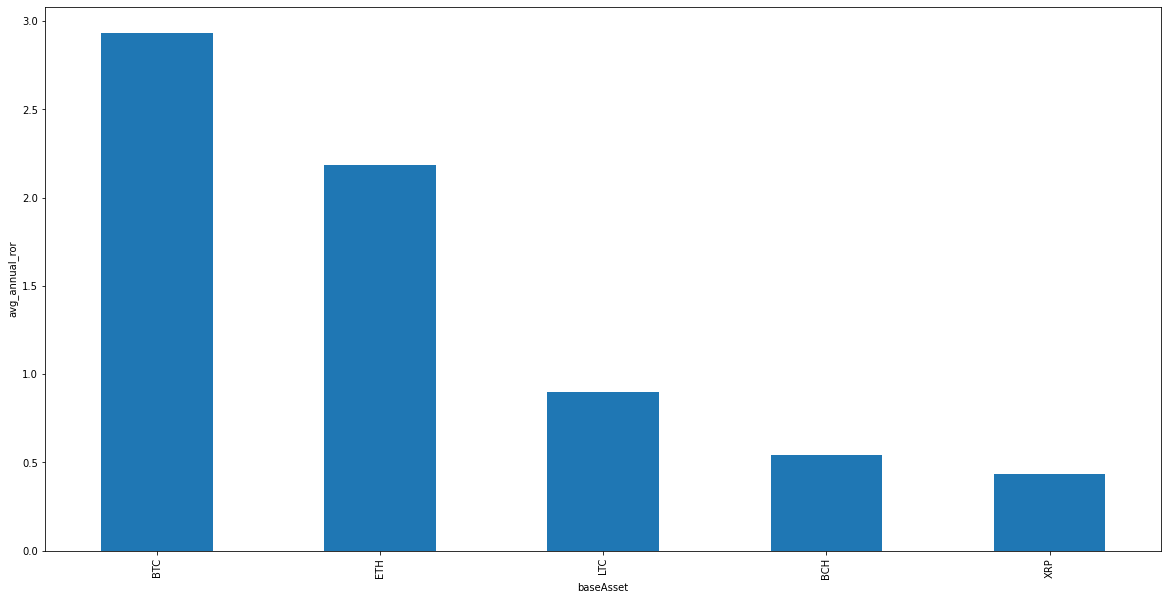

In [ ]:
ax = premia.annual_ror.plot(figsize=(20,10),kind='bar')
ax.set_ylabel("avg_annual_ror")